In [1]:
# %matplotlib qt
import mne, os, glob, pandas as pd, re

mne.set_log_level("warning")

# Retrieve statistics about epochs before and after autoreject
# for different segment durations
# Displayed label counts are counted after autoreject

clean = glob.glob("../data/segmented/*/clean/*-epo.fif")
clean.sort()

dirty = glob.glob("../data/segmented/*/raw/*-epo.fif")
dirty.sort()

assert len(clean) == len(dirty)

zipped = list(zip(dirty, clean))

In [2]:
def get_duration_from_path(path):
    return int(re.search(r"/(\d+)s/", path).group(1))

In [3]:
# Initialize total DataFrame
total = pd.DataFrame(columns=["dur", "post_sam_la", "post_sam_ha", "post_ham_la", "post_ham_ha", "post_stai_la", "post_stai_ha", "pre_sam_la", "pre_sam_ha", "pre_ham_la", "pre_ham_ha", "pre_stai_la", "pre_stai_ha"])

# Get unique durations
durations = set([get_duration_from_path(path) for path, _ in zipped])

# Ensure a row exists for all durations
for dur in durations:
    total.loc[len(total)] = [dur] + [0] * (len(total.columns) - 1)

In [4]:
for pre_ar_path, post_ar_path in zipped:
    pre, post = mne.read_epochs(pre_ar_path), mne.read_epochs(post_ar_path)
    dur = get_duration_from_path(pre_ar_path)

    pre_meta: pd.DataFrame = pre.metadata # type: ignore
    post_meta: pd.DataFrame = post.metadata # type: ignore

    thresholds = {
        "sam": ["post_sam_la", "post_sam_ha", "pre_sam_la", "pre_sam_ha", 1, 2],
        "ham": ["post_ham_la", "post_ham_ha", "pre_ham_la", "pre_ham_ha", 1, 2],
        "stai": ["post_stai_la", "post_stai_ha", "pre_stai_la", "pre_stai_ha", 1, 2]
    }
    
    # Update counts for both pre and post metadata
    for col, (low_key_post, high_key_post, low_key_pre, high_key_pre, low_thresh, high_thresh) in thresholds.items():
        if col in post_meta.columns:
            total.loc[total["dur"] == dur, low_key_post] += (post_meta[col] <= low_thresh).sum()
            total.loc[total["dur"] == dur, high_key_post] += (post_meta[col] >= high_thresh).sum()
        if col in pre_meta.columns:
            total.loc[total["dur"] == dur, low_key_pre] += (pre_meta[col] <= low_thresh).sum()
            total.loc[total["dur"] == dur, high_key_pre] += (pre_meta[col] >= high_thresh).sum()

total

,dur,post_sam_la,post_sam_ha,post_ham_la,post_ham_ha,post_stai_la,post_stai_ha,pre_sam_la,pre_sam_ha,pre_ham_la,pre_ham_ha,pre_stai_la,pre_stai_ha
0,3,775,441,399,817,837,821,880,500,420,960,840,840
1,15,155,81,77,159,168,168,176,100,84,192,168,168


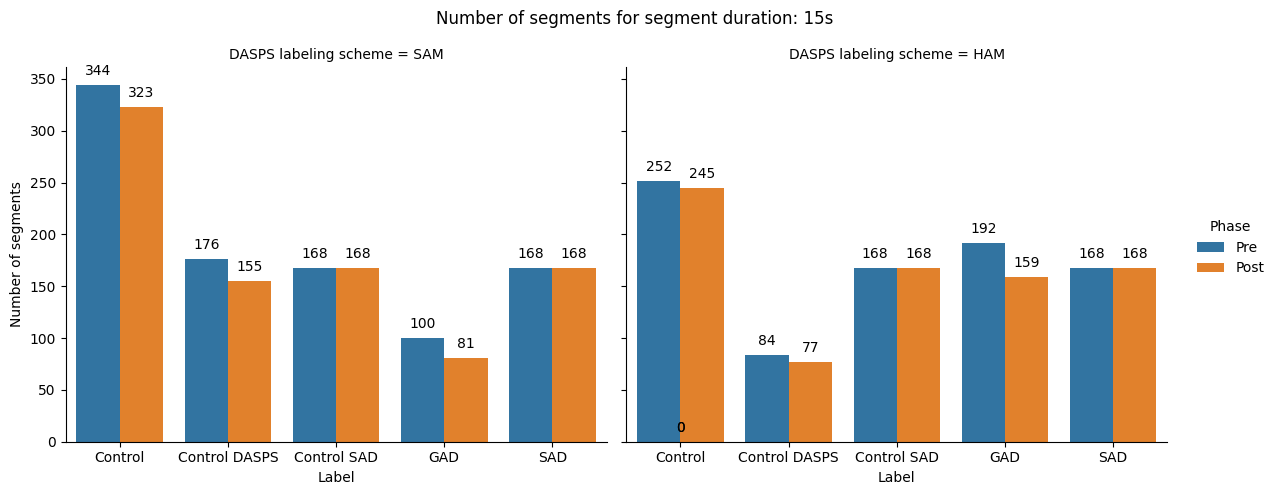

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

stats_for_duration = 15

dur_filtered = total[total["dur"] == stats_for_duration]

d = dur_filtered.to_dict(orient="records")[0]

import pandas as pd

# Data for SAM
df_sam = pd.DataFrame({
    "Control": [d["pre_sam_la"] + d["pre_stai_la"], d["post_sam_la"] + d["post_stai_la"]],
    "Control DASPS": [d["pre_sam_la"], d["post_sam_la"]],
    "Control SAD": [d["pre_stai_la"], d["post_stai_la"]],
    "GAD": [d["pre_sam_ha"], d["post_sam_ha"]],
    "SAD": [d["pre_stai_ha"], d["post_stai_ha"]],
    "DASPS labeling scheme": ["SAM", "SAM"],
    "Phase": ["Pre", "Post"]
})

# Data for HAM
df_ham = pd.DataFrame({
    "Control": [d["pre_ham_la"] + d["pre_stai_la"], d["post_ham_la"] + d["post_stai_la"]],
    "Control DASPS": [d["pre_ham_la"], d["post_ham_la"]],
    "Control SAD": [d["pre_stai_la"], d["post_stai_la"]],
    "GAD": [d["pre_ham_ha"], d["post_ham_ha"]],
    "SAD": [d["pre_stai_ha"], d["post_stai_ha"]],
    "DASPS labeling scheme": ["HAM", "HAM"],
    "Phase": ["Pre", "Post"]
})

joined = pd.concat([df_sam, df_ham])
joined = joined.melt(id_vars=["DASPS labeling scheme", "Phase"], var_name="label", value_name="count")

g = sns.catplot(data=joined, x="label", y="count", kind="bar", aspect=1.2, col="DASPS labeling scheme", hue="Phase")
g.figure.suptitle(f"Number of segments for segment duration: {stats_for_duration}s")
g.set_ylabels("Number of segments")
g.set_xlabels("Label")

# Display numbers above bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha="center", va="center", xytext=(0, 10), textcoords="offset points")

g.tight_layout()

In [6]:
# We can see that HAM labeling for DASPS produces a more balanced dataset
# But HAM labeling has less control DASPS than control SAD, which could be a problem
# If we decrease the number of control SAD, the dataset will be well balanced